<a href="https://colab.research.google.com/github/verneh/datasci/blob/master/mnist_with_keras_verne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST digits classification with Keras

This is part of the Deep Learning Coursera course by National Research University Higher School of Economics. Slightly tweaked to make it work.

In [1]:
# set tf 1.x for colab
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [1]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week2_honor()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-04-23 19:46:19--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-04-23 19:46:20 (57.1 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]



In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)
import keras
print("We are using Keras", keras.__version__)

import sys
sys.path.append("../..")
import keras_utils
from keras_utils import reset_tf_session

We're using TF 1.15.2


Using TensorFlow backend.


We are using Keras 2.0.6


In [0]:
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

# Look at the data

In this task we have 60000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train [shape (60000, 28, 28)] sample patch:
 [[  0  76 246 252 112]
 [  0  85 252 230  25]
 [  0  85 252 223   0]
 [  0  85 252 145   0]
 [  0  86 253 225   0]]
A closeup of a sample patch:


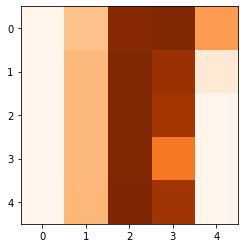

And the whole sample:


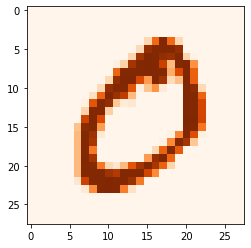

y_train [shape (60000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [101]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Oranges")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Oranges")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

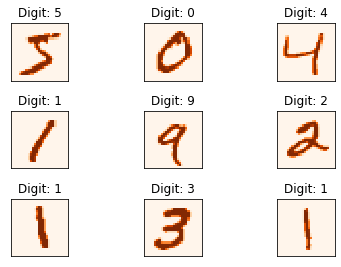

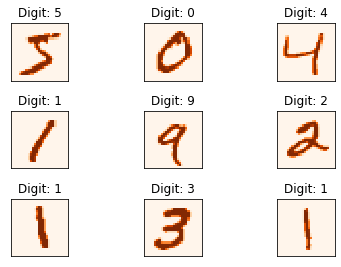

In [102]:
# let's see all the digits.
# https://nextjournal.com/gkoehler/digit-recognition-with-keras
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='Oranges', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [103]:
# flatten images
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_test_flat = X_test.reshape((X_test.shape[0], -1))
print(X_test_flat.shape)

(60000, 784)
(10000, 784)


In [104]:
# one-hot encode the target
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_test_oh = keras.utils.to_categorical(y_test, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [0]:
# we still need to clear a graph though
s = reset_tf_session()

model = Sequential()  # it is a feed-forward network without loops like in RNN
model.add(Dense(512, input_shape=(784,)))  # the first layer must specify the input shape (replacing placeholders)
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

In [106]:
# you can look at all layers and parameter count
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
__________

In [0]:
# now we "compile" the model specifying the loss and optimizer. 
# since this is multiclassification, we're going to run tanh and softmax, adagrad
# overview of optimizers = https://ruder.io/optimizing-gradient-descent/index.html#whichoptimizertouse
# from keras import optimizers
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(
    loss='categorical_crossentropy', # this is our cross-entropy
    optimizer='adagrad',
    metrics=['accuracy']  # report accuracy during training
)

In [108]:
# and now we can fit the model with model.fit()
# and we don't have to write loops and batching manually as in TensorFlow
model.fit(
    X_train_flat, 
    y_train_oh,
    batch_size=512, 
    epochs=40,
    validation_data=(X_test_flat, y_test_oh),
    callbacks=[keras_utils.TqdmProgressCallback()],
    verbose=2
)

Train on 60000 samples, validate on 10000 samples

Epoch 1/40
Epoch 1/40
**************************************************
loss: 0.8061; acc: 0.8042; val_loss: 0.3119; val_acc: 0.9017
5s - loss: 0.8085 - acc: 0.8039 - val_loss: 0.3119 - val_acc: 0.9017

Epoch 2/40
Epoch 2/40
**************************************************
loss: 0.3115; acc: 0.9029; val_loss: 0.2419; val_acc: 0.9276
5s - loss: 0.3114 - acc: 0.9028 - val_loss: 0.2419 - val_acc: 0.9276

Epoch 3/40
Epoch 3/40
**************************************************
loss: 0.2675; acc: 0.9173; val_loss: 0.2043; val_acc: 0.9375
5s - loss: 0.2679 - acc: 0.9173 - val_loss: 0.2043 - val_acc: 0.9375

Epoch 4/40
Epoch 4/40
**************************************************
loss: 0.2384; acc: 0.9272; val_loss: 0.1863; val_acc: 0.9441
5s - loss: 0.2378 - acc: 0.9272 - val_loss: 0.1863 - val_acc: 0.9441

Epoch 5/40
Epoch 5/40
**************************************************
loss: 0.2161; acc: 0.9330; val_loss: 0.1915; val_acc: 0.9431

# Some notes we can do to play around with this.

Here are some tips on what you could do:

 * __Network size__
   * More neurons, 
   * More layers, ([docs](https://keras.io/))

   * Other nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - https://keras.io/regularizers/
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * https://keras.io/preprocessing/image/
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.